In [1]:
import importlib
import sys
sys.path.insert(0, '/cndd/fangming/CEMBA/snmcseq_dev')

from __init__ import *
from __init__jupyterlab import *
from scipy import sparse
import collections
import itertools
import re
import fbpca
import pickle
import scipy.cluster.hierarchy as sch
from sklearn.metrics import euclidean_distances

import snmcseq_utils
importlib.reload(snmcseq_utils)
import CEMBA_run_tsne
import CEMBA_clst_utils
import SCF_utils
importlib.reload(SCF_utils)

import seaborn as sns 
import matplotlib.pyplot as plt

# Configs  

In [2]:
config_dir = '/cndd/fangming/CEMBA/data/MOp_all/data_freeze_neurons/' 
config_f = 'config_scf_8mods_data_freeze_190917.py' 

sys.path.insert(0, config_dir)
exec("from {} import *".format(config_f.split('.')[0]))
previous_summary_results = os.path.join(outdir, 'intg_summary-{}-3-round-clustering.tsv'.format(name))
output_summary_results = os.path.join(outdir, 'intg_summary-{}-4-round-clustering.tsv'.format(name))
print(output_summary_results)


/cndd/fangming/CEMBA/data/MOp_all/results/intg_summary-mop_8mods_0915_k30-4-round-clustering.tsv


In [3]:
# fixed dataset configs
sys.path.insert(0, DATA_DIR)
import __init__datasets
importlib.reload(__init__datasets)
from __init__datasets import *

meta_f = os.path.join(DATA_DIR, '{0}_metadata.tsv')
hvftrs_f = os.path.join(DATA_DIR, '{0}_hvfeatures.{1}')
hvftrs_gene = os.path.join(DATA_DIR, '{0}_hvfeatures.gene')
hvftrs_cell = os.path.join(DATA_DIR, '{0}_hvfeatures.cell')

## Read in data 

In [4]:
log = snmcseq_utils.create_logger()
logging.info('*')

09/26/2019 10:07:07 PM *


In [5]:
metas = collections.OrderedDict()
for mod in mods_selected:
    metas[mod] = pd.read_csv(meta_f.format(mod), sep="\t").reset_index().set_index(settings[mod].cell_col)
    print(mod, metas[mod].shape, len(np.unique(metas[mod][settings[mod].cluster_col])))

snmcseq_gene (9366, 32) 36
snatac_gene (54844, 13) 26
smarter_cells (6244, 129) 57


/cndd/fangming/venvs/conda_dobro/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


smarter_nuclei (5911, 146) 40
10x_cells_v2 (121440, 8) 80
10x_cells_v3 (69727, 8) 68
10x_nuclei_v3 (39706, 8) 61
10x_nuclei_v3_macosko (101647, 19) 76


## All done, making plots after 

- Plotting packages

In [6]:
# get results summary
mods_ordered = [
    'snatac_gene',
    'snmcseq_gene',
    'smarter_nuclei',
    'smarter_cells',
    '10x_cells_v3',
    '10x_nuclei_v3',
    '10x_nuclei_v3_macosko',
    '10x_cells_v2', 
    ]
assert set(mods_ordered) == set(mods_selected)

f = previous_summary_results

df_info = pd.read_csv(f, sep="\t", index_col='sample') 
cluster_col_round_previous = 'cluster_round_3'
cluster_col_round_current = 'cluster_round_4'
df_info[cluster_col_round_current] = np.nan

main_clusters = df_info[cluster_col_round_previous].unique()
n_clsts_round_previous = len(main_clusters)
print(main_clusters)

df_info_sub = []
for main_cluster in main_clusters:
    f = os.path.join(outdir, 'intg_summary_{}_sub{}.tsv'.format(name, main_cluster))
    df = pd.read_csv(f, sep='\t')
    df_modify = (df.filter(regex='^cluster', axis=1)
                   .applymap(lambda x: "{}-{}".format(main_cluster, x))
                )
    df.update(df_modify)
    df_info_sub.append(df)
df_info_sub = pd.concat(df_info_sub).set_index('sample').rename(columns={'cluster_joint_r0.1': cluster_col_round_current})
# assert ~np.any(df_info_sub[cluster_col_round_current].values)
df_info.update(df_info_sub[[cluster_col_round_current]])
                                         
print(df_info.shape)
print(len(df_info['cluster_round_2'].unique()))
print(len(df_info['cluster_round_3'].unique()))
print(len(df_info['cluster_round_4'].unique()))
print(len(df_info['cluster_joint_r0.1'].unique()))
print(len(df_info['cluster_joint_r1'].unique()))
print(len(df_info['cluster_joint_r1'].unique()))
df_info.head()

/cndd/fangming/venvs/conda_dobro/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


['1-1-1' '4-2-1' '4-1-1' '4-2-2' '6-2-1' '1-2-1' '6-4-2' '1-2-2' '3-1-2'
 '3-2-1' '5-3-2' '2-1-2' '7-2-2' '3-1-1' '2-1-1' '7-1-2' '5-3-1' '7-2-1'
 '9-2-2' '6-5-1' '6-1-2' '5-4-1' '5-2-1' '9-2-1' '5-1-2' '5-1-1' '6-5-2'
 '2-2-1' '4-2-3' '2-3-1' '6-1-1' '6-6-1' '6-3-1' '6-4-1' '6-3-2' '6-5-3'
 '3-3-1' '5-2-2' '9-1-1' '7-1-1' '2-3-2' '2-3-3' '5-2-3' '6-3-3' '10-1-1'
 '5-5-1' '3-2-2' '8-2-1' '2-2-2' '4-1-2' '8-3-1' '8-1-1' '8-1-2' '2-2-3'
 '2-2-4' '8-3-2']
(408885, 16)
29
56
100
10
26
26


,cluster_joint_r0.1,cluster_joint_r1,cluster_joint_r2,cluster_joint_r4,tsne_x_joint,tsne_y_joint,modality,modality_name,cluster,annot,cluster_round_2,cluster_round_2_anno,cluster_round_3,cluster_round_3_anno,cluster_round_3_color,cluster_round_4
sample,,,,,,,,,,,,,,,,
snmcseq_gene_2C_M_0,1,11,10,23,0.471629,-3.134735,snmcseq_gene,DNA methylation,L4-IT-Rorb_Rorb-Tenm2,L4-IT-Rorb_Rorb-Tenm2,1-1,L5 IT Rspo1_1,1-1-1,L5 IT Rspo1_1,#3CBC78,1-1-1-1
snmcseq_gene_2C_M_1,4,1,8,4,-2.414973,-12.098081,snmcseq_gene,DNA methylation,L23-IT-Cux2,L23-IT-Cux2,4-2,L2/3 IT,4-2-1,L2/3 IT,#6F836B,4-2-1-1
snmcseq_gene_2C_M_100,4,1,8,49,-1.446751,-12.051894,snmcseq_gene,DNA methylation,L23-IT-Cux2,L23-IT-Cux2,4-1,L2/3 IT,4-1-1,L2/3 IT,#6F836B,4-1-1-1
snmcseq_gene_2C_M_1000,4,1,8,49,-1.901734,-13.660591,snmcseq_gene,DNA methylation,L23-IT-Cux2,L23-IT-Cux2,4-2,L2/3 IT,4-2-1,L2/3 IT,#6F836B,4-2-1-1
snmcseq_gene_2C_M_1001,4,1,8,10,-0.981086,-11.936621,snmcseq_gene,DNA methylation,L23-IT-Cux2,L23-IT-Cux2,4-1,L2/3 IT,4-1-1,L2/3 IT,#6F836B,4-1-1-1


In [7]:
# joint_cluster = 'cluster_round_4'

# # mod colors and names
# mod_colors = collections.OrderedDict({mod: settings[mod].color for mod in mods_ordered})
# mod_names = {mod: settings[mod].name for mod in mods_ordered}

# # get cluster centroids
# centroids = {}
# _x = (df_info[['tsne_x_joint', 'tsne_y_joint', 'annot', 'modality']]
#              .groupby(['modality', 'annot']).median())
# for mod in mods_selected:
#     centroids[mod] = _x.loc[mod, :]
# centroids['joint'] = (df_info[['tsne_x_joint', 'tsne_y_joint', joint_cluster]]
#              .groupby([joint_cluster]).median())

# # get annotation for joint clusters 
# joint_annot = df_info[df_info['modality'].isin(features_selected)].groupby([joint_cluster]).agg({'annot': lambda x: x.value_counts().index.values[0]})
# df_info[joint_cluster+'_anno'] = df_info[joint_cluster].apply(lambda x: joint_annot.loc[x, 'annot'])

# # get uniq colors for joint clusters  
# clsts = np.sort(df_info[joint_cluster].unique())
# colors = snmcseq_utils.gen_colors(len(clsts))
# joint_clst_colors = {clst: color for clst, color in zip(clsts, colors)}

# # histograms
# hist = df_info.groupby([joint_cluster, 'modality']).size().unstack().fillna(0).astype(int)
# hist_mod = hist.sum(axis=0)
# hist_clst = hist.sum(axis=1)

# hist_frac = hist.divide(hist_clst, axis=0)
# hist_exp = pd.DataFrame(np.outer(hist_clst/hist_clst.sum(), hist_mod), 
#              index=hist_clst.index, columns=hist_mod.index.values)
# hist_enrich = (hist+1)/(hist_exp+1)
# print(df_info.shape)
# df_info.head()

In [8]:
joint_cluster = 'cluster_round_4'

# mod colors and names
mod_colors = collections.OrderedDict({mod: settings[mod].color for mod in mods_ordered})
mod_names = {mod: settings[mod].name for mod in mods_ordered}

# get cluster centroids
centroids = {}
_x = (df_info[['tsne_x_joint', 'tsne_y_joint', 'annot', 'modality']]
             .groupby(['modality', 'annot']).median())
for mod in mods_selected:
    centroids[mod] = _x.loc[mod, :]
centroids['joint'] = (df_info[['tsne_x_joint', 'tsne_y_joint', joint_cluster]]
             .groupby([joint_cluster]).median())

# get annotation for joint clusters 
joint_annot = df_info[df_info['modality'].isin(features_selected)].groupby([joint_cluster]).agg({'annot': lambda x: x.value_counts().index.values[0]})
joint_annot = pd.merge(joint_annot, 
                       metas['10x_cells_v2'].groupby(settings['10x_cells_v2'].annot_col).first()[['cluster_color']], 
                       left_on='annot', 
                       right_index=True,
                      )
df_info[joint_cluster+'_anno'] = df_info[joint_cluster].apply(lambda x: joint_annot.loc[x, 'annot'])
df_info[joint_cluster+'_color'] = df_info[joint_cluster].apply(lambda x: joint_annot.loc[x, 'cluster_color'])

# # get uniq colors for joint clusters (new)
joint_clst_colors = joint_annot['cluster_color'].to_dict()
# # get uniq colors for joint clusters (old) 
# clsts = np.sort(df_info[joint_cluster].unique())
# colors = snmcseq_utils.gen_colors(len(clsts))
# joint_clst_colors = {clst: color for clst, color in zip(clsts, colors)}

# histograms
hist = df_info.groupby([joint_cluster, 'modality']).size().unstack().fillna(0).astype(int)
hist_mod = hist.sum(axis=0)
hist_clst = hist.sum(axis=1)
hist_frac = hist.divide(hist_clst, axis=0)
hist_exp = pd.DataFrame(np.outer(hist_clst/hist_clst.sum(), hist_mod), 
             index=hist_clst.index, columns=hist_mod.index.values)
hist_enrich = (hist+1)/(hist_exp+1)

# clst_order 
clsts_order = df_info.groupby(joint_cluster).size().sort_values(ascending=False).index.values

print(df_info.shape)
df_info.head()

(408885, 18)


,cluster_joint_r0.1,cluster_joint_r1,cluster_joint_r2,cluster_joint_r4,tsne_x_joint,tsne_y_joint,modality,modality_name,cluster,annot,cluster_round_2,cluster_round_2_anno,cluster_round_3,cluster_round_3_anno,cluster_round_3_color,cluster_round_4,cluster_round_4_anno,cluster_round_4_color
sample,,,,,,,,,,,,,,,,,,
snmcseq_gene_2C_M_0,1,11,10,23,0.471629,-3.134735,snmcseq_gene,DNA methylation,L4-IT-Rorb_Rorb-Tenm2,L4-IT-Rorb_Rorb-Tenm2,1-1,L5 IT Rspo1_1,1-1-1,L5 IT Rspo1_1,#3CBC78,1-1-1-1,L5 IT Rspo1_1,#3CBC78
snmcseq_gene_2C_M_1,4,1,8,4,-2.414973,-12.098081,snmcseq_gene,DNA methylation,L23-IT-Cux2,L23-IT-Cux2,4-2,L2/3 IT,4-2-1,L2/3 IT,#6F836B,4-2-1-1,L2/3 IT,#6F836B
snmcseq_gene_2C_M_100,4,1,8,49,-1.446751,-12.051894,snmcseq_gene,DNA methylation,L23-IT-Cux2,L23-IT-Cux2,4-1,L2/3 IT,4-1-1,L2/3 IT,#6F836B,4-1-1-1,L2/3 IT,#6F836B
snmcseq_gene_2C_M_1000,4,1,8,49,-1.901734,-13.660591,snmcseq_gene,DNA methylation,L23-IT-Cux2,L23-IT-Cux2,4-2,L2/3 IT,4-2-1,L2/3 IT,#6F836B,4-2-1-1,L2/3 IT,#6F836B
snmcseq_gene_2C_M_1001,4,1,8,10,-0.981086,-11.936621,snmcseq_gene,DNA methylation,L23-IT-Cux2,L23-IT-Cux2,4-1,L2/3 IT,4-1-1,L2/3 IT,#6F836B,4-1-1-1,L2/3 IT,#6F836B


In [9]:
df_info.to_csv(output_summary_results, sep="\t", na_rep='NA', header=True, index=True)
df_info.head()

,cluster_joint_r0.1,cluster_joint_r1,cluster_joint_r2,cluster_joint_r4,tsne_x_joint,tsne_y_joint,modality,modality_name,cluster,annot,cluster_round_2,cluster_round_2_anno,cluster_round_3,cluster_round_3_anno,cluster_round_3_color,cluster_round_4,cluster_round_4_anno,cluster_round_4_color
sample,,,,,,,,,,,,,,,,,,
snmcseq_gene_2C_M_0,1,11,10,23,0.471629,-3.134735,snmcseq_gene,DNA methylation,L4-IT-Rorb_Rorb-Tenm2,L4-IT-Rorb_Rorb-Tenm2,1-1,L5 IT Rspo1_1,1-1-1,L5 IT Rspo1_1,#3CBC78,1-1-1-1,L5 IT Rspo1_1,#3CBC78
snmcseq_gene_2C_M_1,4,1,8,4,-2.414973,-12.098081,snmcseq_gene,DNA methylation,L23-IT-Cux2,L23-IT-Cux2,4-2,L2/3 IT,4-2-1,L2/3 IT,#6F836B,4-2-1-1,L2/3 IT,#6F836B
snmcseq_gene_2C_M_100,4,1,8,49,-1.446751,-12.051894,snmcseq_gene,DNA methylation,L23-IT-Cux2,L23-IT-Cux2,4-1,L2/3 IT,4-1-1,L2/3 IT,#6F836B,4-1-1-1,L2/3 IT,#6F836B
snmcseq_gene_2C_M_1000,4,1,8,49,-1.901734,-13.660591,snmcseq_gene,DNA methylation,L23-IT-Cux2,L23-IT-Cux2,4-2,L2/3 IT,4-2-1,L2/3 IT,#6F836B,4-2-1-1,L2/3 IT,#6F836B
snmcseq_gene_2C_M_1001,4,1,8,10,-0.981086,-11.936621,snmcseq_gene,DNA methylation,L23-IT-Cux2,L23-IT-Cux2,4-1,L2/3 IT,4-1-1,L2/3 IT,#6F836B,4-1-1-1,L2/3 IT,#6F836B


In [10]:
def plot_1():
    from matplotlib.gridspec import GridSpec

    sample_n = min(len(df_info), 20000)
    n_resolutions = len(resolutions)
    fig = plt.figure(figsize=(8*2,6*2))
    gs = GridSpec(2, n_resolutions)

    ax = fig.add_subplot(gs[0, :])
    kw_colors = {settings[mod].name: settings[mod].color for mod in mods_ordered}
    tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', 'modality_name'
    legend_kws = {'bbox_to_anchor': (1, 1), 'loc': 'upper left'}
    snmcseq_utils.plot_tsne_labels_ax(df_info, ax, tx, ty, tc, 
                                      legend_kws=legend_kws,
                                      kw_colors=kw_colors,
                                      sample_n=sample_n,
                                      legend_size=30,
                                      rasterized=True,
                                      s=2,
                                     )
    ax.set_aspect('equal')
    ax.axis('off')

    layouts = [(1, i) for i in range(n_resolutions)]
    for resolution, layout in zip(resolutions, layouts):
        ax = fig.add_subplot(gs[layout[0], layout[1]])
        tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', 'cluster_joint_r{}'.format(resolution)
        snmcseq_utils.plot_tsne_labels_ax(df_info, ax, tx, ty, tc, 
                                          legend_mode=-1,
                                          sample_n=sample_n,
                                          rasterized=True,
                                          s=2,
                                         )
        ax.set_aspect('equal')
        ax.axis('off')
        ax.set_title('{} joint clusters (r={})'.format(len(df_info[tc].unique()), resolution))

    fig.tight_layout()
    fig.savefig(output_figures.format(1, 'pdf'), bbox_inches='tight', dpi=300)
    plt.show()

In [11]:
# plot_1()

In [12]:
def plot_1_single(kw_colors='', show_labels=False, output=''):
    """plot umap cluster 
    """
    fig, ax = plt.subplots(1, 1, figsize=(8*1,8*1))
    tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', joint_cluster
    legend_kws = {'bbox_to_anchor': (1, 1), 'loc': 'upper left'}
    snmcseq_utils.plot_tsne_labels_ax(df_info, ax, tx, ty, tc, 
                                         #  legend_kws=legend_kws,
                                      sample_n=sample_n,
                                      legend_size=30,
                                      rasterized=True,
                                      kw_colors=kw_colors,
                                      legend_mode=-1,
                                      s=2,
                                     )
    ax.set_aspect('equal')
    ax.axis('off')
    if show_labels:
        for clst, centroid in centroids['joint'].iterrows():
            facecolor='white'
            ax.text(centroid.values[0], 
                    centroid.values[1], 
                    str(clst)+'_'+joint_annot.loc[clst, 'annot'],
                    color='black', 
                    bbox=dict(facecolor=facecolor, alpha=0.3, edgecolor='black', boxstyle='round,pad=0.1'),
                    fontsize=10,
                   )

    fig.savefig(output, bbox_inches='tight', dpi=300)
    plt.show()
        
def plot_2_single(output=''):
    """Plot umap - modality
    """
    fig, ax = plt.subplots(1, 1, figsize=(8*1,8*1))
    kw_colors = {settings[mod].name: settings[mod].color for mod in mods_selected}
    tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', 'modality_name'
    legend_kws = {'bbox_to_anchor': (1, 1), 'loc': 'upper left'}
    snmcseq_utils.plot_tsne_labels_ax(df_info, ax, tx, ty, tc, 
                                      legend_kws=legend_kws,
                                      sample_n=sample_n,
                                      legend_size=30,
                                      rasterized=True,
                                      kw_colors=kw_colors,
                                      s=2,
                                     )
    ax.set_aspect('equal')
    ax.axis('off')

    fig.savefig(output, bbox_inches='tight', dpi=300)
    plt.show()

def plot_3(output='', 
           show_labels=False):
    """Plot umap - cluster - each modality
    """
    n = len(mods_selected)
    nx = 3
    ny = int((n+nx-1)/nx)
    fig, axs = plt.subplots(ny, nx, figsize=(6*nx,6*ny))
    axs = axs.flatten()
    tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', 'cluster'

    for ax, mod in zip(axs, mods_selected):
        snmcseq_utils.plot_tsne_labels_ax(df_info[df_info['modality']==mod], ax, tx, ty, tc, 
                                          sample_n=sample_n,
                                          legend_mode=-1,
                                          rasterized=True,
                                          s=2,
                                         )
        ax.set_title('{} ({} clusters)'.format(settings[mod].name, len(df_info.loc[df_info['modality']==mod, tc].unique())))
    
        if show_labels:
            for clst, centroid in centroids[mod].iterrows():
                facecolor='white'
                ax.text(centroid.values[0], 
                        centroid.values[1], 
                        clst,
                        color='black', 
                        bbox=dict(facecolor=facecolor, alpha=0.3, edgecolor='black', boxstyle='round,pad=0.1'),
                        fontsize=10,
                       )
        ax.set_aspect('equal')
        ax.axis('off')
    for ax in axs[n:]:
        ax.axis('off')


    fig.subplots_adjust(wspace=0.05, hspace=0.05)
    fig.savefig(output, bbox_inches='tight', dpi=300)
    plt.show()


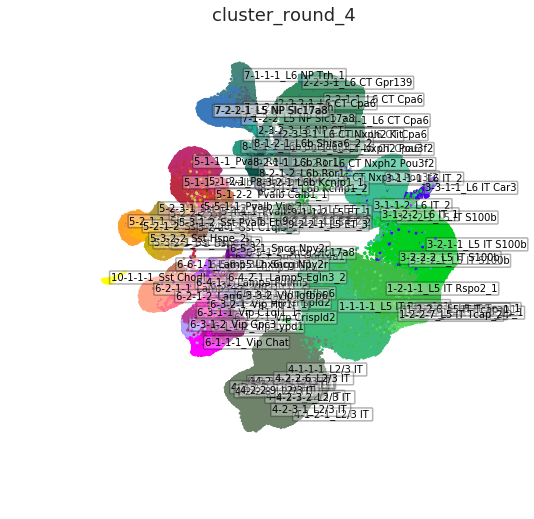

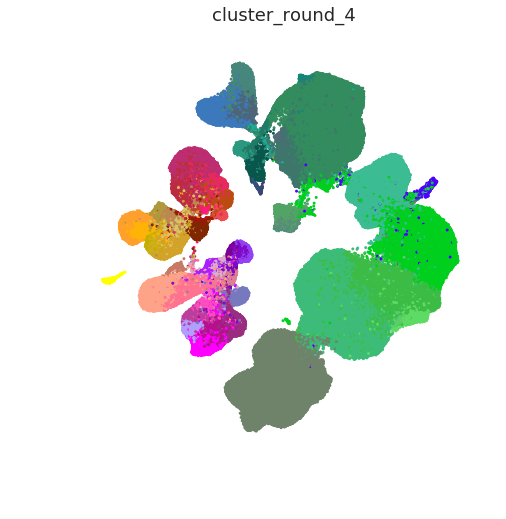

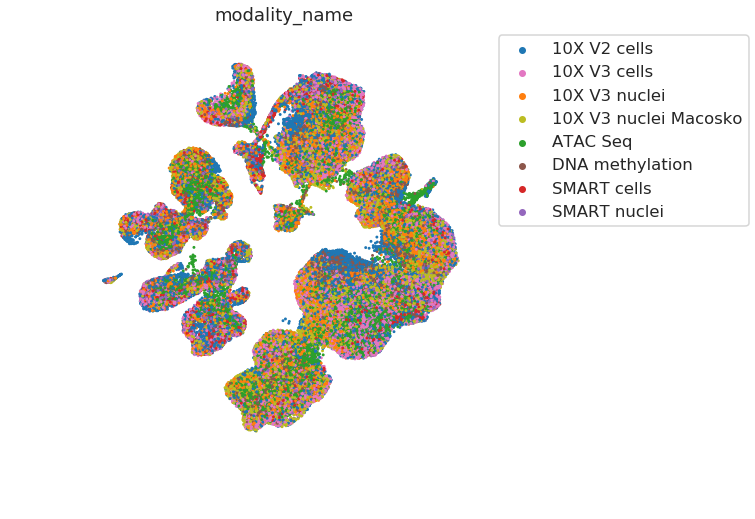

In [13]:
sample_n = 20000
# umap cluster
plot_1_single(joint_clst_colors, show_labels=True, output=output_figures.format('round4_1-label', 'pdf'))
plot_1_single(joint_clst_colors, show_labels=False, output=output_figures.format('round4_1-nolabel', 'pdf'))
plot_2_single(output=output_figures.format('round4_2-nolabel', 'pdf'))

In [14]:
# # umap modality
# plot_3(show_labels=True, output=output_figures.format('3-label', 'pdf'))
# plot_3(show_labels=False, output=output_figures.format('3-nolabel', 'pdf'))

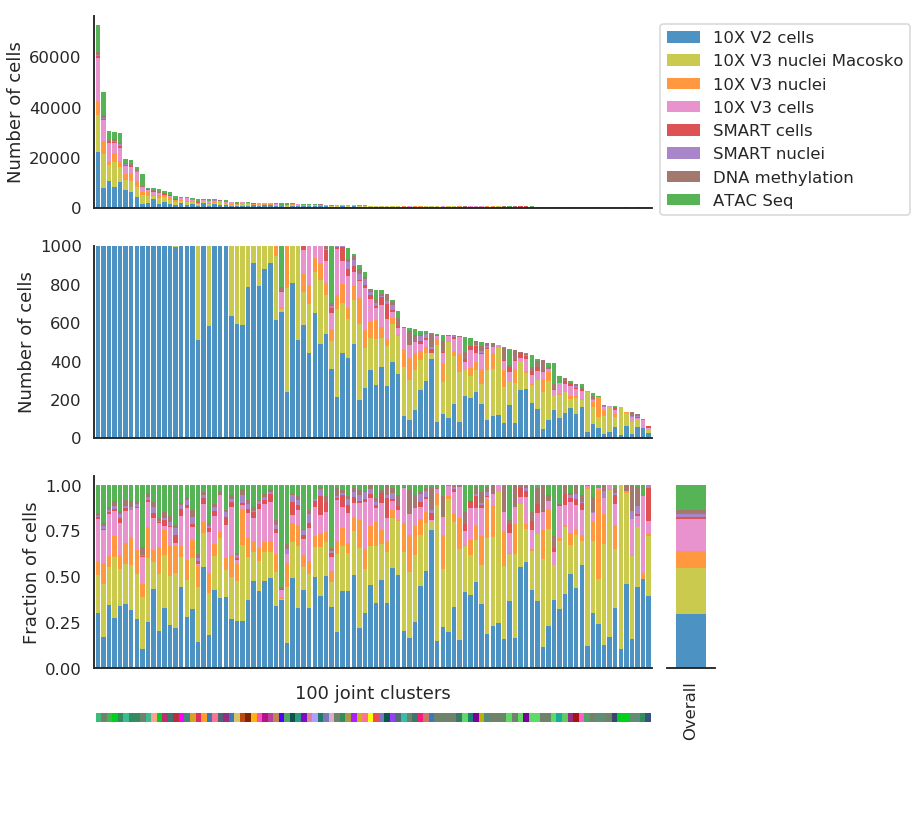

In [15]:

clsts_order = df_info.groupby(joint_cluster).size().sort_values(ascending=False).index.values

# histograms
with sns.axes_style('white', {"patch.edgecolor": "black", 'patch.force_edgecolor': False,}):
    fig, axs = plt.subplots(3, 1, figsize=(10,4*3))
#     ax = axs[0]
    for i, ax in enumerate(axs[:2]):
        if i == 0:
            legend = True
        else:
            legend = False
        (hist[mods_ordered[::-1]].rename(index=mod_names, columns=mod_names)
                                 .reindex(clsts_order)
                                 .plot.bar(stacked=True, width=0.8, alpha=0.8, ax=ax,
                                           legend=legend,
                                          color=[val for key, val in mod_colors.items()][::-1], # this controls mod_colors
                                         )
        )
        sns.despine(ax=ax)
        ax.set_ylabel('Number of cells')
        ax.set_xlabel('')
        ax.set_xticklabels([])
        
    axs[0].legend(bbox_to_anchor=(1, 1))
    axs[1].set_ylim([0, 1000])
    
    ax = axs[2]
    (hist_frac[mods_ordered[::-1]].rename(index=mod_names, columns=mod_names)
                             .reindex(clsts_order)
                             .plot.bar(stacked=True, width=0.8, alpha=0.8, ax=ax, legend=False, 
                                      color=[val for key, val in mod_colors.items()][::-1], # this controls mod_colors
                                     )
    )
    sns.despine(ax=ax)
    ax.set_ylabel('Fraction of cells')
    ax.set_xlabel('{} joint clusters'.format(len(hist)))
    ax.set_xticklabels([])
    
#     ax = fig.add_axes([.95, .5, .05, .4])
    left_x, left_y, width, height = ax.get_position().bounds
    ax = fig.add_axes((left_x+width+0.2*(1-(left_x+width)), left_y, 0.3*(1-width), height))
    ((hist_mod/hist_mod.sum()).loc[mods_ordered[::-1]].to_frame().T.rename({0: 'Overall'}, axis=0)
                              .plot.bar(stacked=True, width=0.8, alpha=0.8, ax=ax, legend=False, 
                                      color=[val for key, val in mod_colors.items()][::-1]) # this controls mod_colors
    )
    sns.despine(left=True, ax=ax)
    ax.set_ylabel('')
    ax.set_yticklabels([])
    
    ax = fig.add_axes((left_x, left_y-0.5*left_y, width, 0.05*height))
    to_plot = pd.DataFrame()
    to_plot['color'] = joint_annot.loc[hist.reindex(clsts_order).index, 'cluster_color']
    to_plot['bar'] = 1
    (to_plot['bar'].plot.bar(stacked=True, width=1, 
                     alpha=1, 
                      ax=ax, 
                      legend=False, 
                     color=to_plot['color'].values, 
                     )
    )
    ax.axis('off')
    
#     fig.tight_layout()
    fig.savefig(output_figures.format('round4_4', 'pdf'), bbox_inches='tight')
    plt.show()

#### Heatmap of correlation of cluster centroids 
- imputed data

In [16]:
mods_included = mods_selected
mod_reference = features_selected[0]
cells_all = np.load(output_cells_all, allow_pickle=True)
imputed_data = np.load(output_imputed_data_format.format(mod_reference), allow_pickle=True)

# cluster centroids of imputed data
cluster_centroids = collections.OrderedDict()
for (clst, mod), df_sub in df_info.groupby([joint_cluster, 'modality']):
    if mod in mods_included:
        cells_sub = df_sub.index.values
        cells_sub_idx = snmcseq_utils.get_index_from_array(cells_all, cells_sub)
        if mod not in cluster_centroids.keys():
            cluster_centroids[mod] = {}
        cluster_centroids[mod][clst] = np.ravel(imputed_data[cells_sub_idx,:].mean(axis=0))
# print(cluster_centroids)

# Saving the objects:
with open(output_cluster_centroids, 'wb') as f: 
    pickle.dump((
                cluster_centroids
                ), f)

In [17]:
cluster_centroids_df = collections.OrderedDict()
for mod in mods_selected:
    if mod in mods_included:
        cluster_centroids_df[mod] = pd.DataFrame(cluster_centroids[mod])

# each modality and cluster
uniq_clusters = df_info[joint_cluster].unique()
corr_grand_clusters = np.hstack([[mod+'_'+str(clst)
                                for clst in cluster_centroids_df[mod].columns.values]
                                for mod in mods_included])

# grand correlation matrix
corr_grand = {}
for i, mod_x in enumerate(mods_included):
    for j, mod_y in enumerate(mods_included):
        if j >= i:
            gene_x = cluster_centroids_df[mod_x].index.values
            gene_y = cluster_centroids_df[mod_y].index.values
            gene_common = np.intersect1d(gene_x, gene_y)
            _x = (cluster_centroids_df[mod_x].loc[gene_common]).rank(axis=0).T.values
            _y = (cluster_centroids_df[mod_y].loc[gene_common]).rank(axis=0).T.values
            corr = np.corrcoef(_x, _y)[:len(_x), len(_x):]
            corr_grand[(i, j)] = corr
            if j != i:
                corr_grand[(j, i)] = corr.T
                
corr_grand = np.hstack([np.vstack([
                    corr_grand[(i, j)] for i in range(len(mods_included))
                    ])
                for j in range(len(mods_included))
                ])

# labels
# corr_grand_label = np.hstack([[str(clst) + "_" + str(joint_annot.loc[clst, 'annot'])
#                                for clst in cluster_centroids_df[mod].columns.values] 
#                             for mod in mods_included
#                             ])
corr_grand_label = np.hstack([[str(joint_annot.loc[clst, 'annot'])
                               for clst in cluster_centroids_df[mod].columns.values] 
                            for mod in mods_included
                            ])
corr_grand_clsts = np.hstack([cluster_centroids_df[mod].columns.values
                            for mod in mods_included
                            ])
corr_grand_mods = np.hstack([
                            [mod]*len(cluster_centroids_df[mod].columns.values) for mod in mods_included
                            ])

# colors
corr_grand_mod_colors = np.array([settings[mod].color for mod in corr_grand_mods])
corr_grand_clst_colors = np.array([joint_clst_colors[clst] for clst in corr_grand_clsts])

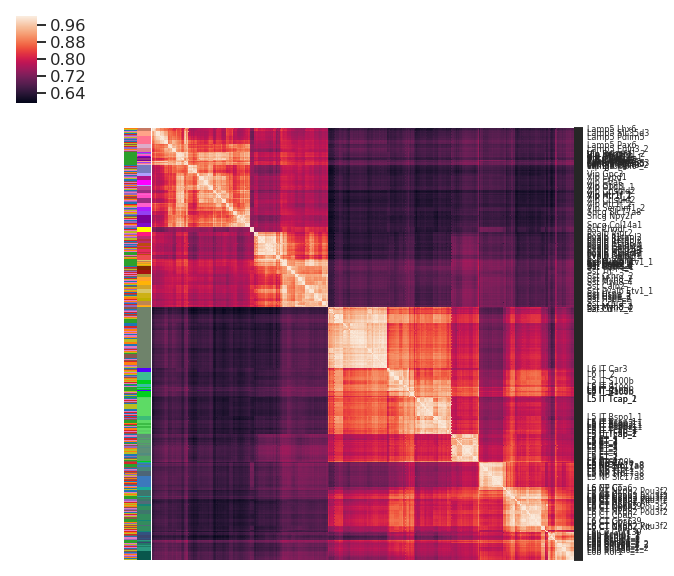

In [18]:
mat = corr_grand
Z = sch.linkage(mat, method='average')
dn = sch.dendrogram(Z, no_plot=True)

g = sns.clustermap(mat[dn['leaves'],:][:,dn['leaves']], 
                   row_cluster=False, col_cluster=False,
                   row_colors=[corr_grand_mod_colors[dn['leaves']], 
                               corr_grand_clst_colors[dn['leaves']], 
                              ], 
                   yticklabels=snmcseq_utils.dedup_array_elements(corr_grand_label[dn['leaves']]),
                   xticklabels=[],
#                    figsize=(8, 12),
                  )
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize=8)
g.savefig(output_figures.format('round4_8_cluster_heatmap', 'pdf'), bbox_inches='tight')
plt.show()

In [19]:
def plot_5_version2(base_cluster, joint_cluster, 
                    order_joint,
           output='',
          ):
    nx = len(mods_ordered)
    ny = 2
    heatmap_kws = {
        'xticklabels': False, 
        'yticklabels': False,
        'vmin': 0, 
        'vmax': 1,
        'cmap': 'Reds',
    }

    cbar_kws = {
        'orientation': 'vertical', 
        'label': 'Fraction of cells',
    }

    with sns.plotting_context('talk'):
        fig, axs = plt.subplots(ny, nx, figsize=(3*nx, 3*ny))
        axs = axs.T
        cbar_ax = fig.add_axes([0.95, 0.4, 0.03, 0.3])
        njoint_clusters = len(df_info[joint_cluster].unique())
        for i, (mod, ax) in enumerate(zip(mods_ordered[::-1], axs)):
            conf_mat = pd.crosstab(df_info.loc[df_info['modality']==mod, base_cluster], 
                                   df_info.loc[df_info['modality']==mod, joint_cluster],
                                  ) #.fillna(0)
            # normalize each joint cluster
            conf_mat_njoint = conf_mat.divide(conf_mat.sum(axis=0), axis=1)
            # normalize each orig cluster
            conf_mat_norig = conf_mat.divide(conf_mat.sum(axis=1), axis=0)

            # plot normalized by joint 
            if i == 0:
                ylabel = 'Row normalized\n{} joint clusters'.format(njoint_clusters)
                cbar = True
            else:
                ylabel = ''
                cbar = False
                
            order_joint = order_joint_sch
            _X = conf_mat_njoint.reindex(order_joint, axis=1, fill_value=0) 
            _rX, ri, rc = snmcseq_utils.diag_matrix_rows(_X.values, _X.index.values, _X.columns.values)
            _rX = pd.DataFrame(_rX, index=ri, columns=rc)
            g = sns.heatmap(_rX.T, 
                        cbar=cbar,
                        cbar_kws=cbar_kws,
                        cbar_ax=cbar_ax,
                        ax=ax[0],
                        **heatmap_kws,
                       )
            g.axes.set_title('{}\n{} clusters'.format(settings[mod].name, _rX.shape[0]))
            g.axes.set_ylabel(ylabel)
            order_orig = _rX.index.values # Will be fixed for the mod clusters  
            # bounding box
            for _, spine in g.axes.spines.items():
                spine.set_visible(True)
                spine.set_color(settings[mod].color)

            # plot normalized by orig (according to the axis of normalized by joint) 
            _X = conf_mat_norig.reindex(order_orig, axis=0).reindex(order_joint, axis=1).fillna(0)
            g = sns.heatmap(_X.T, 
                        cbar=False,
                        ax=ax[1],
                        **heatmap_kws,
                       )
            if i == 0:
                g.axes.set_xlabel('')
                g.axes.set_ylabel('Col normalized\n{} joint clusters'.format(njoint_clusters))
            else:
                g.axes.set_xlabel('')
                g.axes.set_ylabel('')
            # bounding box
            for _, spine in g.axes.spines.items():
                spine.set_visible(True)
                spine.set_color(settings[mod].color)

        plt.subplots_adjust(hspace=0.05, wspace=0.05)
        fig.savefig(output, bbox_inches='tight')
        plt.show()

In [20]:
# get cluster order
_mat = pd.DataFrame(cluster_centroids['10x_cells_v2']).T
Z = sch.linkage(_mat.values, method='average')
order_joint_sch = _mat.index.values[sch.dendrogram(Z, no_plot=True)['leaves']]

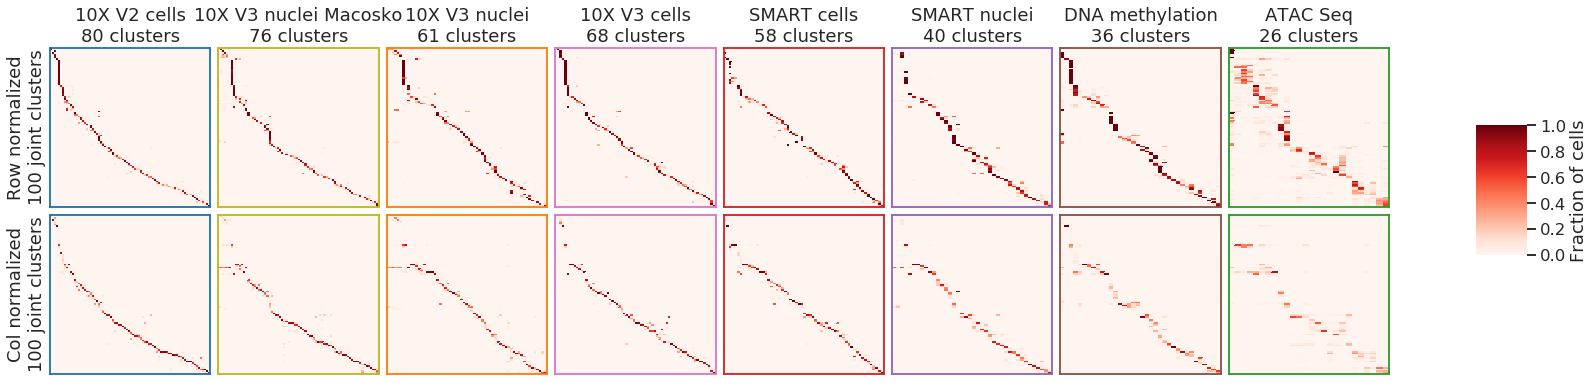

In [21]:
base_cluster = 'cluster'
plot_5_version2(base_cluster, joint_cluster, order_joint_sch, 
       output=output_figures.format('round4_5', 'pdf'),
       )

### tSNE plot 

In [22]:
# cluster centroids of imputed data
base_cluster = 'cluster'
cluster_centroids_single = collections.OrderedDict()
for (clst, mod), df_sub in df_info.groupby([base_cluster, 'modality']):
    if mod in mods_included:
        cells_sub = df_sub.index.values
        cells_sub_idx = snmcseq_utils.get_index_from_array(cells_all, cells_sub)
        if mod not in cluster_centroids_single.keys():
            cluster_centroids_single[mod] = {}
        cluster_centroids_single[mod][clst] = np.ravel(imputed_data[cells_sub_idx,:].mean(axis=0))
        
cluster_centroids_single['intg'] = {}
for clst, df_sub in df_info.groupby([joint_cluster]):
    cells_sub = df_sub.index.values
    cells_sub_idx = snmcseq_utils.get_index_from_array(cells_all, cells_sub)
    cluster_centroids_single['intg'][clst] = np.ravel(imputed_data[cells_sub_idx,:].mean(axis=0))

In [23]:
base_annot = df_info.groupby(['modality', 'cluster']).first()[['annot']].reset_index()
intg_annot = joint_annot.reset_index().rename(columns={joint_cluster: 'cluster'})
intg_annot['modality'] = 'intg'
annots = pd.concat([base_annot, intg_annot], sort=False)

In [24]:
# cluster_centroids
# cluster_meta
dfs = []
centroids_meta = []
        
for mod, mod_centroids in cluster_centroids_single.items():
    df = pd.DataFrame(mod_centroids)
    for col in df.columns.values:
        centroids_meta.append({
            'modality': mod,
            'cluster': col,
            })
    df.columns = [mod + '_' + str(col) for col in df.columns.values]
    dfs.append(df)
dfs = pd.concat(dfs, axis=1)

centroids_meta = pd.DataFrame(centroids_meta)
centroids_meta['sample'] = (centroids_meta['modality'] + '_' + centroids_meta['cluster'].astype(str)).values

print(centroids_meta.shape)
centroids_meta.head()

df_umap = CEMBA_run_tsne.run_umap(dfs, n_neighbors=10, n_pc=50, min_dist=0.7)
df_umap = df_umap.join(centroids_meta.set_index('sample'))
df_umap = pd.merge(df_umap.reset_index(), annots, on=['cluster', 'modality']).set_index('sample')

print(df_umap.shape)
df_umap.head()

(545, 3)


09/26/2019 10:17:07 PM Running tsne: 50 PC, 10 n_neighbors, 0.7 min_dist , 2 dim.
Input shape: (4067, 545)
09/26/2019 10:17:13 PM Done with tSNE. running time: 5.793078660964966 seconds.


(547, 6)


,tsne_x,tsne_y,cluster,modality,annot,cluster_color
sample,,,,,,
10x_cells_v2_1,-7.893719,-11.648685,1,10x_cells_v2,Lamp5 Pax6,NaN
10x_cells_v2_10,-9.075269,2.593596,10,10x_cells_v2,Sncg Npy2r,NaN
10x_cells_v2_11,-10.971150,3.667899,11,10x_cells_v2,Sncg Calb1_1,NaN
10x_cells_v2_12,-10.024338,3.305253,12,10x_cells_v2,Sncg Calb1_2,NaN
10x_cells_v2_13,-9.828078,0.932603,13,10x_cells_v2,Vip Crispld2,NaN


09/26/2019 10:17:13 PM No handles with labels found to put in legend.


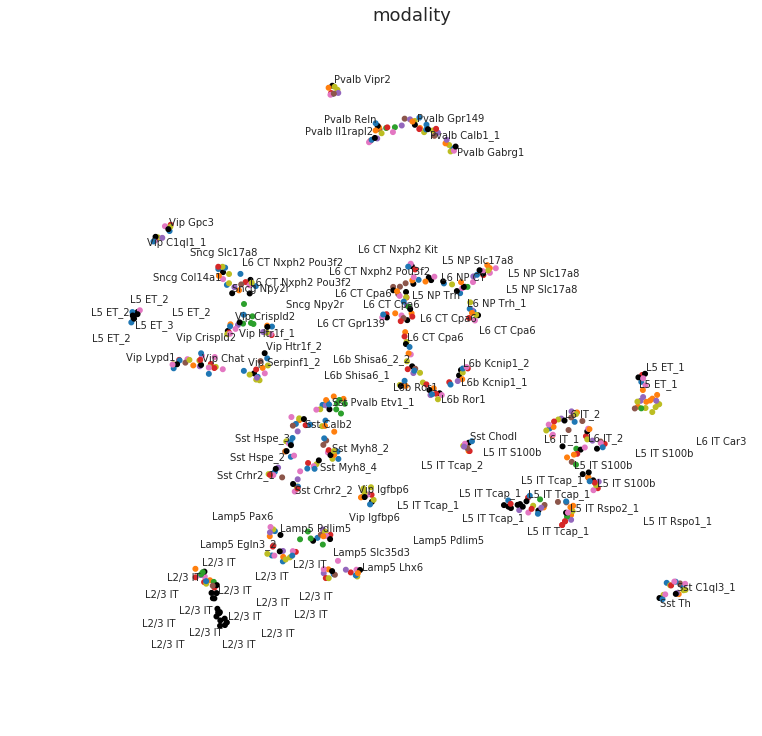

In [25]:
from adjustText import adjust_text
np.random.seed(0)

kw_colors = mod_colors.copy()
kw_colors['intg'] = 'black'

fig, ax = plt.subplots(figsize=(12,12))
tx, ty, tc = 'tsne_x', 'tsne_y', 'modality'
legend_kws = {'bbox_to_anchor': (1, 1), 'loc': 'upper left'}
# cond = df_umap['annot'].str.contains(r'^Pv')
cond = ~df_umap['modality'].isnull()
snmcseq_utils.plot_tsne_labels_ax(df_umap[cond], ax, tx, ty, tc, 
                                  legend_kws=legend_kws,
                                  kw_colors=kw_colors,
                                  sample_n=sample_n,
#                                   legend_size=30,
                                  legend_mode=-1,
                                  rasterized=True,
                                  s=20,
                                 )
texts = []
for idx, row in df_umap[df_umap['modality']=='intg'].iterrows():
    _x, _y, _label = row[tx], row[ty], row['annot']
    texts.append(ax.text(_x, _y, _label))
adjust_text(texts)
# ax.set_aspect('equal')
ax.get_legend().remove()
ax.axis('off')
output = output_figures.format('round4_10', 'pdf')
fig.savefig(output, dpi=300, bbox_inches='tight')
plt.show()

# Gene level features:

In [26]:
df_genes = pd.read_csv(PATH_GENEBODY_ANNOTATION, sep='\t')
df_genes['gene_id_abbr'] = df_genes['gene_id'].apply(lambda x: x.split('.')[0])
df_genes = df_genes.set_index('gene_id_abbr')
print(df_genes.shape)
df_genes.head()

(53379, 7)


,gene_id,gene_name,chr,start,end,strand,gene_type
gene_id_abbr,,,,,,,
ENSMUSG00000102693,ENSMUSG00000102693.1,4933401J01Rik,chr1,3073253,3074322,+,TEC
ENSMUSG00000064842,ENSMUSG00000064842.1,Gm26206,chr1,3102016,3102125,+,snRNA
ENSMUSG00000051951,ENSMUSG00000051951.5,Xkr4,chr1,3205901,3671498,-,protein_coding
ENSMUSG00000102851,ENSMUSG00000102851.1,Gm18956,chr1,3252757,3253236,+,processed_pseudogene
ENSMUSG00000103377,ENSMUSG00000103377.1,Gm37180,chr1,3365731,3368549,-,TEC


In [27]:
df_genes_v2 = df_genes.reset_index().groupby('gene_name').first()
df_genes_v2.head()

,gene_id_abbr,gene_id,chr,start,end,strand,gene_type
gene_name,,,,,,,
0610005C13Rik,ENSMUSG00000109644,ENSMUSG00000109644.1,chr7,45567794,45575327,-,antisense_RNA
0610006L08Rik,ENSMUSG00000108652,ENSMUSG00000108652.1,chr7,74818818,74853813,-,lincRNA
0610009B22Rik,ENSMUSG00000007777,ENSMUSG00000007777.9,chr11,51685386,51688874,-,protein_coding
0610009E02Rik,ENSMUSG00000086714,ENSMUSG00000086714.1,chr2,26445696,26459390,+,processed_transcript
0610009L18Rik,ENSMUSG00000043644,ENSMUSG00000043644.4,chr11,120348678,120351190,+,bidirectional_promoter_lncRNA


In [28]:
f_meta_format = '{0}/{1}_metadata.tsv'
f_data_format = '{0}/{1}_{2}raw.{3}'
f_hvftr_format = '{0}/{1}_hvfeatures.{2}'
f_ftr_format = '{0}/{1}_features.{2}'

In [29]:
gxc_ftrs = {}
for mod in mods_selected:
    ti = time.time()
    print(mod)
    
    # read data matrix
    if settings[mod].mod_category == 'mc':
        f_data = f_ftr_format.format(DATA_DIR, mod, 'tsv')
        # read in files
        print(mod, "Reading in files {}".format(time.time()-ti))
        gxc_ftrs[mod] = pd.read_csv(f_data, sep='\t', index_col=0)
        print(time.time()-ti)
        
    else:
        f_data = f_ftr_format.format(DATA_DIR, mod, 'npz') 
        f_data_gene = f_ftr_format.format(DATA_DIR, mod, 'gene') 
        f_data_cell = f_ftr_format.format(DATA_DIR, mod, 'cell') 
        
        # read in files
        print(mod, "Reading in files {}".format(time.time()-ti))
        gxc_ftrs[mod] = snmcseq_utils.load_gc_matrix(f_data_gene, f_data_cell, f_data) # checked dimensions in agreement internally
        print(gxc_ftrs[mod].data.shape)
        print(time.time()-ti)
    
    print(mod, "Total time used: {}".format(time.time()-ti))
    

snmcseq_gene
snmcseq_gene Reading in files 5.626678466796875e-05
102.73538756370544
snmcseq_gene Total time used: 102.73557162284851
snatac_gene
snatac_gene Reading in files 3.457069396972656e-05
(53278, 54844)
27.967490434646606
snatac_gene Total time used: 27.967519998550415
smarter_cells
smarter_cells Reading in files 0.0005505084991455078
(32324, 6244)
9.273253440856934
smarter_cells Total time used: 9.273278951644897
smarter_nuclei
smarter_nuclei Reading in files 3.910064697265625e-05
(32324, 5911)
5.297345161437988
smarter_nuclei Total time used: 5.297366619110107
10x_cells_v2
10x_cells_v2 Reading in files 4.291534423828125e-05
(31053, 121440)
54.21881985664368
10x_cells_v2 Total time used: 54.2188458442688
10x_cells_v3
10x_cells_v3 Reading in files 0.0003085136413574219
(31053, 69727)
74.06175518035889
10x_cells_v3 Total time used: 74.06179356575012
10x_nuclei_v3
10x_nuclei_v3 Reading in files 4.935264587402344e-05
(31053, 39706)
22.627822160720825
10x_nuclei_v3 Total time used:

In [30]:
# genes_inq = [
#     'Tshz2',
# #     'Bcl6', 
# #     'Slco2a1', 
# #     'Hpgd', 
# #     'Npsr1', 
# #     'Tshz2',
# ]
    
# sample_n = 5000

# with sns.axes_style('white'):
#     n = len(mods_ordered)
#     nx = 9
#     ny = int((n+nx-1)/nx)
#     fig, axs = plt.subplots(ny, nx, figsize=(3*nx,3*ny))
#     axs = axs.flatten()
#     tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', genes_inq[0]
    
#     cbar_ax = fig.add_axes([0.9, 0.2, 0.05, 0.6])
    
#     for i, (ax, mod) in enumerate(zip(axs, mods_ordered[::-1])):
#         if settings[mod].mod_category == 'mc':
#             genes = gxc_ftrs[mod].index.values
#             gene_ids_inq = df_genes_v2.reindex(genes_inq)['gene_id_abbr'].values 
#             gene_idx = snmcseq_utils.get_index_from_array(genes, gene_ids_inq)
#             gene_data = gxc_ftrs[mod].iloc[gene_idx].T.rename(columns={gene_ids_inq[0]: genes_inq[0]})
#             # normalize gene_data
#         else:
#             genes = gxc_ftrs[mod].gene
#             cells = gxc_ftrs[mod].cell
#             gene_ids_inq = df_genes_v2.reindex(genes_inq)['gene_id_abbr'].values 
#             gene_idx = snmcseq_utils.get_index_from_array(genes, gene_ids_inq)
#             gene_data = np.ravel(gxc_ftrs[mod].data.tocsr()[gene_idx, :].todense())
#             gene_data = pd.Series(gene_data, index=cells).to_frame(genes_inq[0])
            
# #             # normalize gene_data
# #             gene_data = gene_data.applymap(lambda x: np.log10(x+1))
        
#         # normalize gene_data
#         gene_data = settings[mod].mod_direction*(gene_data - gene_data.mean())/gene_data.std()

#         df_mod = df_info[df_info['modality']==mod]
#         if sample_n > len(df_mod):
#             df_plot = pd.merge(gene_data, df_mod, left_index=True, right_index=True)
#         else:
#             df_plot = (pd.merge(gene_data, df_mod, left_index=True, right_index=True)
#                          .sample(sample_n, replace=False)
#                       )
    
#         if i == 0: 
#             cbar = False
#         else:
#             cbar = False
#         snmcseq_utils.plot_tsne_values_ax(df_plot, ax, tx, ty, tc, 
#                                           s=2,
#                                           cbar=cbar,
#                                           cbar_ax=cbar_ax,
#                                           cmap='rocket_r',
#                                           rasterized=True,
#                                          )
#         ax.set_title('{} '.format(settings[mod].name, ))
# #         ax.set_title('')
#         ax.set_xticks([])
#         ax.set_yticks([])
#         ax.set_aspect('auto')
        
#         for _, spine in ax.spines.items():
#             spine.set_color(settings[mod].color)
#             spine.set_linewidth(3)
        
#     for ax in axs[n:]:
#         ax.axis('off')
#     cbar_ax.axis('off')
        
    
#     fig.subplots_adjust(hspace=0.05, wspace=0.05)
#     fig.savefig(output_figures.format('6_{}'.format(genes_inq[0]), 'pdf'), bbox_inches='tight', dpi=300)
#     plt.show()
    

### Genes heatmap (old) 

In [31]:
# genes_inq = [
#     'Snap25',
    
#     'Satb2',
#     'Camk2a',
#     'Tbr1',
    
#     'Gad1',
#     'Gad2',
#     'Slc6a1',
    
#     'Cux1',
#     'Cux2',
#     'Rorb',
#     'Deptor',
#     'Vat1l',
#     'Sulf1',
#     'Tle4',
#     'Foxp2',
#     'Grik3',
#     'Bcl6',
#     'Tshz2', 
    
#     'Lhx6',
#     'Adarb2',
    
#     'Pvalb',
#     'Sox6',
#     'Gria1',
    
#     'Prox1',
#     'Sv2c',
#     ]

# clsts_uniq = np.sort(np.unique(df_info[joint_cluster]))

# df_plots = {} 
# for i, (ax, mod) in enumerate(zip(axs, mods_ordered[::-1])):
#     if settings[mod].mod_category == 'mc':
#         genes = gxc_ftrs[mod].index.values
#         gene_ids_inq = df_genes_v2.reindex(genes_inq)['gene_id_abbr'].values 
#         gene_idx = snmcseq_utils.get_index_from_array(genes, gene_ids_inq)
#         gene_data = (gxc_ftrs[mod].iloc[gene_idx].T
#                                   .rename(columns={a: b for a, b in zip(gene_ids_inq, genes_inq)})
#                     )
#         # normalize gene_data
#     else:
#         genes = gxc_ftrs[mod].gene
#         cells = gxc_ftrs[mod].cell
#         gene_ids_inq = df_genes_v2.reindex(genes_inq)['gene_id_abbr'].values 
#         gene_idx = snmcseq_utils.get_index_from_array(genes, gene_ids_inq)
#         gene_idx = gene_idx[gene_idx!=-1] # remove -1
        
#         gene_data = gxc_ftrs[mod].data.tocsr()[gene_idx, :].todense().T
#         gene_data = (pd.DataFrame(gene_data, index=cells, columns=gene_ids_inq)
#                        .rename(columns={a: b for a, b in zip(gene_ids_inq, genes_inq)})
#                     )
# #         # normalize gene_data
    
    
#     df_mod = df_info.loc[df_info['modality']==mod, [joint_cluster]]
#     if sample_n > len(df_mod):
#         df_plot = pd.merge(gene_data, df_mod, left_index=True, right_index=True)
#     else:
#         df_plot = (pd.merge(gene_data, df_mod, left_index=True, right_index=True)
#                      .sample(sample_n, replace=False)
#                   )
#     df_plot = df_plot.groupby(joint_cluster).mean()
    
#     # normalize gene_data
#     df_plot = settings[mod].mod_direction*df_plot
#     df_plots[mod] = df_plot.T.reindex(
#                                     index=genes_inq, 
#                                     columns=clsts_uniq,
#                                     )

In [32]:
# import scipy.cluster.hierarchy as sch
# with sns.plotting_context('talk'), sns.axes_style('white'):
#     n = len(mods_ordered)
#     nx = 9
#     ny = int((n+nx-1)/nx)
#     fig, axs = plt.subplots(ny, nx, figsize=(5*nx,5*ny))
#     axs = axs.flatten()
#     tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', genes_inq[0]
#     cbar_ax = fig.add_axes([0.9, 0.2, 0.05, 0.6])
    
#     for i, (ax, mod) in enumerate(zip(axs, mods_ordered[::-1])):
#         if i == 0: 
#             cbar = False
#             # row gene
#             Z = sch.linkage(df_plots[mod].fillna(0), method='average', metric='euclidean', optimal_ordering=True)
#             dn = sch.dendrogram(Z, no_plot=True)['leaves']
#             # col clst
#             Z = sch.linkage(df_plots[mod].fillna(0).T, method='average', metric='euclidean', optimal_ordering=True)
#             dn_clst = sch.dendrogram(Z, no_plot=True)['leaves']
#         else:
#             cbar = False
            
#         g = sns.heatmap(df_plots[mod].iloc[dn, dn_clst], ax=ax, 
#                                      cbar=cbar,
#                                     yticklabels=True,
#                                      cbar_ax=cbar_ax,
#                                      cmap='rocket_r',
#                                      )
#         g.set_facecolor('#fffff2')
#         ax.set_title('{} '.format(settings[mod].name, ))
#         ax.set_xticks([])
        
#         if i == 0:
#             ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
#         else:
#             ax.set_yticks([])
#         ax.set_xlabel('')
            
#         ax.set_aspect('auto')
        
#         for _, spine in ax.spines.items():
#             spine.set_color(settings[mod].color)
#             spine.set_linewidth(3)
        
#     for ax in axs[n:]:
#         ax.axis('off')
#     cbar_ax.axis('off')
        
    
#     fig.subplots_adjust(hspace=0.05, wspace=0.05)
#     fig.savefig(output_figures.format('round4_old_7_gene_heatmap', 'pdf'), bbox_inches='tight')
#     plt.show()
    

### Genes heatmap (new) 

In [33]:
genes_inq = [
    # neuron
    'Snap25',
    # Exc
    'Satb2',
    # Inh 
    'Gad2',
    
    # Projecting (IT ET CT L6b)
    'Pde1a', # Pan-projection 
    # NP
    'Tshz2', 
    # MGE
    'Sox6',
    'Lhx6',
    # CGE
    'Adarb2',
    
    # IT
    'Slc30a3',
    # IT sub
    # L2-4 
    'Cux2',
    # L4-5
    'Rorb',
    # L5 
    'Deptor',
    # L6
    'Oprk1',
    
    # L5 ET
    'Bcl6',
    
    # L6 CT
    'Foxp2',
    # L6b
    'Nxph4',
    
    # NP again
    'Trhr',
    'Rapgef3',
    'Slc17a8',
    
    # Pv
    'Pvalb',
    'Th',
    'Tac1',
    'Mme',
    'Unc5b',
    # Sst
    'Calb1',
    'Crhr2',
    'Hpse',
    'Chodl',
    
    # Vip Serpinf1
    'Calb2',
    'Vip',
    'Chat',
    'Col15a1',
    'Serpinf1',
    
    # Lamp5 Sncg
    'Lamp5',
    'Sv2c',
    'Plch2',
    'Ntn1',
    
    'Ndnf',
#     'Pax6',
#     'Nr2f2',
    'Reln',
    ]

# assert len(set(genes_inq)) == len(genes_inq)
print([item for item, count in collections.Counter(genes_inq).items() if count > 1])

genes_intersection = set()
for mod in mods_selected:
    if settings[mod].mod_category == 'mc':
        genes = gxc_ftrs[mod].index.values
    else:
        genes = gxc_ftrs[mod].gene
        
    if len(genes_intersection) > 0:
        genes_intersection = set(genes) & set(genes_intersection)
    else:
        genes_intersection = genes 
print(len(genes_intersection))
genes_intersection = df_genes.loc[genes_intersection, 'gene_name'].values
for gene in genes_inq:
    if gene not in genes_intersection:
        print(gene)

[]
15543


In [34]:
joint_annot.sort_values('annot')['annot'].to_dict()

{'1-1-1-1': 'L5 IT Rspo1_1',
 '1-2-1-1': 'L5 IT Rspo2_1',
 '1-2-2-1': 'L5 IT Tcap_1',
 '1-2-2-2': 'L5 IT Tcap_1',
 '1-2-2-3': 'L5 IT Tcap_1',
 '1-2-2-4': 'L5 IT Tcap_1',
 '1-2-2-5': 'L5 IT Tcap_1',
 '1-2-2-6': 'L5 IT Tcap_1',
 '1-2-2-7': 'L5 IT Tcap_2',
 '10-1-1-1': 'Sst Chodl',
 '2-1-1-1': 'L6 CT Cpa6',
 '2-1-2-1': 'L6 CT Cpa6',
 '2-2-1-1': 'L6 CT Cpa6',
 '2-2-2-1': 'L6 CT Cpa6',
 '2-2-3-1': 'L6 CT Gpr139',
 '2-2-4-1': 'L6 CT Cpa6',
 '2-3-1-1': 'L6 CT Nxph2 Pou3f2',
 '2-3-2-1': 'L6 CT Nxph2 Pou3f2',
 '2-3-2-2': 'L6 CT Nxph2 Pou3f2',
 '2-3-2-3': 'L6 NP CT',
 '2-3-3-1': 'L6 CT Nxph2 Kit',
 '3-1-1-1': 'L6 IT_2',
 '3-1-1-2': 'L6 IT_2',
 '3-1-2-1': 'L5 IT S100b',
 '3-1-2-2': 'L6 IT_1',
 '3-2-1-1': 'L5 IT S100b',
 '3-2-2-1': 'L5 IT S100b',
 '3-2-2-2': 'L5 IT S100b',
 '3-3-1-1': 'L6 IT Car3',
 '4-1-1-1': 'L2/3 IT ',
 '4-1-2-1': 'L2/3 IT ',
 '4-2-1-1': 'L2/3 IT ',
 '4-2-2-1': 'L2/3 IT ',
 '4-2-2-10': 'L2/3 IT ',
 '4-2-2-11': 'L2/3 IT ',
 '4-2-2-2': 'L2/3 IT ',
 '4-2-2-3': 'L2/3 IT ',
 '4-2-2-

In [35]:
clsts_manual_order = collections.OrderedDict({
 '4-1-1-1': 'L2/3 IT ',
 '4-1-2-1': 'L2/3 IT ',
 '4-2-1-1': 'L2/3 IT ',
 '4-2-2-1': 'L2/3 IT ',
 '4-2-2-10': 'L2/3 IT ',
 '4-2-2-11': 'L2/3 IT ',
 '4-2-2-2': 'L2/3 IT ',
 '4-2-2-3': 'L2/3 IT ',
 '4-2-2-4': 'L2/3 IT ',
 '4-2-2-5': 'L2/3 IT ',
 '4-2-2-6': 'L2/3 IT ',
 '4-2-2-7': 'L2/3 IT ',
 '4-2-2-8': 'L2/3 IT ',
 '4-2-2-9': 'L2/3 IT ',
 '4-2-3-1': 'L2/3 IT ',
 '4-2-3-2': 'L2/3 IT ',
    
 '1-1-1-1': 'L5 IT Rspo1_1',
 '1-2-1-1': 'L5 IT Rspo2_1',
 '1-2-2-1': 'L5 IT Tcap_1',
 '1-2-2-2': 'L5 IT Tcap_1',
 '1-2-2-3': 'L5 IT Tcap_1',
 '1-2-2-4': 'L5 IT Tcap_1',
 '1-2-2-5': 'L5 IT Tcap_1',
 '1-2-2-6': 'L5 IT Tcap_1',
 '1-2-2-7': 'L5 IT Tcap_2',
    
 '3-1-1-1': 'L6 IT_2',
 '3-1-1-2': 'L6 IT_2',
 '3-1-2-1': 'L5 IT S100b',
 '3-1-2-2': 'L6 IT_1',
 '3-2-1-1': 'L5 IT S100b',
 '3-2-2-1': 'L5 IT S100b',
 '3-2-2-2': 'L5 IT S100b',
 '3-3-1-1': 'L6 IT Car3',
    
 '9-1-1-1': 'L5 ET_1',
 '9-1-1-2': 'L5 ET_1',
 '9-2-1-1': 'L5 ET_2',
 '9-2-1-2': 'L5 ET_2',
 '9-2-1-3': 'L5 ET_2',
 '9-2-1-4': 'L5 ET_2',
 '9-2-2-1': 'L5 ET_3', 
    
 '2-1-1-1': 'L6 CT Cpa6',
 '2-1-2-1': 'L6 CT Cpa6',
 '2-2-1-1': 'L6 CT Cpa6',
 '2-2-2-1': 'L6 CT Cpa6',
 '2-2-3-1': 'L6 CT Gpr139',
 '2-2-4-1': 'L6 CT Cpa6',
 '2-3-1-1': 'L6 CT Nxph2 Pou3f2',
 '2-3-2-1': 'L6 CT Nxph2 Pou3f2',
 '2-3-2-2': 'L6 CT Nxph2 Pou3f2',
 '2-3-2-3': 'L6 NP CT',
 '2-3-3-1': 'L6 CT Nxph2 Kit',
    
 '8-1-1-1': 'L6b Shisa6_1',
 '8-1-2-1': 'L6b Shisa6_2_2',
 '8-2-1-1': 'L6b Ror1',
 '8-2-1-2': 'L6b Ror1',
 '8-3-1-1': 'L6b Kcnip1_2',
 '8-3-2-1': 'L6b Kcnip1_1',
    
 '7-1-1-1': 'L6 NP Trh_1',
 '7-1-2-1': 'L5 NP Trh',
 '7-1-2-2': 'L5 NP Slc17a8',
 '7-2-1-1': 'L5 NP Slc17a8',
 '7-2-2-1': 'L5 NP Slc17a8',
    
 '5-1-1-1': 'Pvalb Reln',
 '5-1-1-2': 'Pvalb Il1rapl2',
 '5-1-2-1': 'Pvalb Gpr149',
 '5-1-2-2': 'Pvalb Calb1_1',
 '5-4-1-1': 'Pvalb Gabrg1',
 '5-5-1-1': 'Pvalb Vipr2',
    
 '5-2-1-1': 'Sst Myh8_2',
 '5-2-1-2': 'Sst Myh8_4',
 '5-2-2-1': 'Sst C1ql3_1',
 '5-2-2-2': 'Sst Crhr2_1',
 '5-2-2-3': 'Sst Th',
 '5-2-3-1': 'Sst Crhr2_2',
 '5-3-1-1': 'Sst Calb2',
 '5-3-1-2': 'Sst Pvalb Etv1_1',
 '5-3-2-1': 'Sst Hspe_3',
 '5-3-2-2': 'Sst Hspe_2',
 '10-1-1-1': 'Sst Chodl',
    
 '6-3-1-1': 'Vip C1ql1_1',
 '6-3-1-2': 'Vip Gpc3',
 '6-3-2-1': 'Vip Htr1f_1',
 '6-3-2-2': 'Vip Htr1f_2',
 '6-3-3-1': 'Vip Igfbp6',
 '6-3-3-2': 'Vip Igfbp6',
 '6-1-1-1': 'Vip Chat',
 '6-1-1-2': 'Vip Lypd1',
 '6-1-2-1': 'Vip Crispld2',
 '6-1-2-2': 'Vip Crispld2',
 '6-5-2-1': 'Vip Serpinf1_2',
 '6-5-1-1': 'Sncg Col14a1',
 '6-5-1-2': 'Sncg Slc17a8',
 '6-5-3-1': 'Sncg Npy2r',
 '6-5-3-2': 'Sncg Npy2r',
    
 '6-2-1-1': 'Lamp5 Slc35d3',
 '6-2-1-2': 'Lamp5 Pdlim5',
 '6-4-1-1': 'Lamp5 Pdlim5',
 '6-4-2-1': 'Lamp5 Egln3_2',
 '6-4-2-2': 'Lamp5 Pax6',
 '6-6-1-1': 'Lamp5 Lhx6',
})
    
clsts_uniq = np.array(list(clsts_manual_order.keys()))

In [41]:
sample_n = 1e7

20000

In [42]:
# clsts_uniq = np.sort(np.unique(df_info[joint_cluster]))

for i, mod in enumerate(mods_ordered[::-1]):
    if settings[mod].mod_category == 'mc':
        genes = gxc_ftrs[mod].index.values
        gene_ids_inq = df_genes_v2.reindex(genes_inq)['gene_id_abbr'].values 
        gene_idx = snmcseq_utils.get_index_from_array(genes, gene_ids_inq)
        gene_idx = gene_idx[gene_idx!=-1] # remove -1
        gene_data = (gxc_ftrs[mod].iloc[gene_idx].T
                                  .rename(columns={a: b for a, b in zip(gene_ids_inq, genes_inq)})
                    )
        # normalize gene_data
    else:
        genes = gxc_ftrs[mod].gene
        cells = gxc_ftrs[mod].cell
        gene_ids_inq = df_genes_v2.reindex(genes_inq)['gene_id_abbr'].values 
        gene_idx = snmcseq_utils.get_index_from_array(genes, gene_ids_inq)
        gene_idx = gene_idx[gene_idx!=-1] # remove -1
        
        gene_data = gxc_ftrs[mod].data.tocsr()[gene_idx, :].todense().T
        gene_data = (pd.DataFrame(gene_data, index=cells, columns=gene_ids_inq)
                       .rename(columns={a: b for a, b in zip(gene_ids_inq, genes_inq)})
                    )
#         # normalize gene_data
    
    
    df_mod = df_info.loc[df_info['modality']==mod, [joint_cluster]]
    if sample_n > len(df_mod):
        df_plot = pd.merge(gene_data, df_mod, left_index=True, right_index=True)
    else:
        df_plot = (pd.merge(gene_data, df_mod, left_index=True, right_index=True)
                     .sample(sample_n, replace=False)
                  )
    df_plot = df_plot.groupby(joint_cluster).mean()
    
    # normalize gene_data for each row except for mC (already normalized)
    df_plot = settings[mod].mod_direction*df_plot
    if settings[mod].mod_category != 'mc':
        df_plot = df_plot.divide(df_plot.max(axis=1), axis=0)
        
    df_plots[mod] = df_plot.T.reindex(
                                    index=genes_inq, 
                                    columns=clsts_uniq,
                                    )

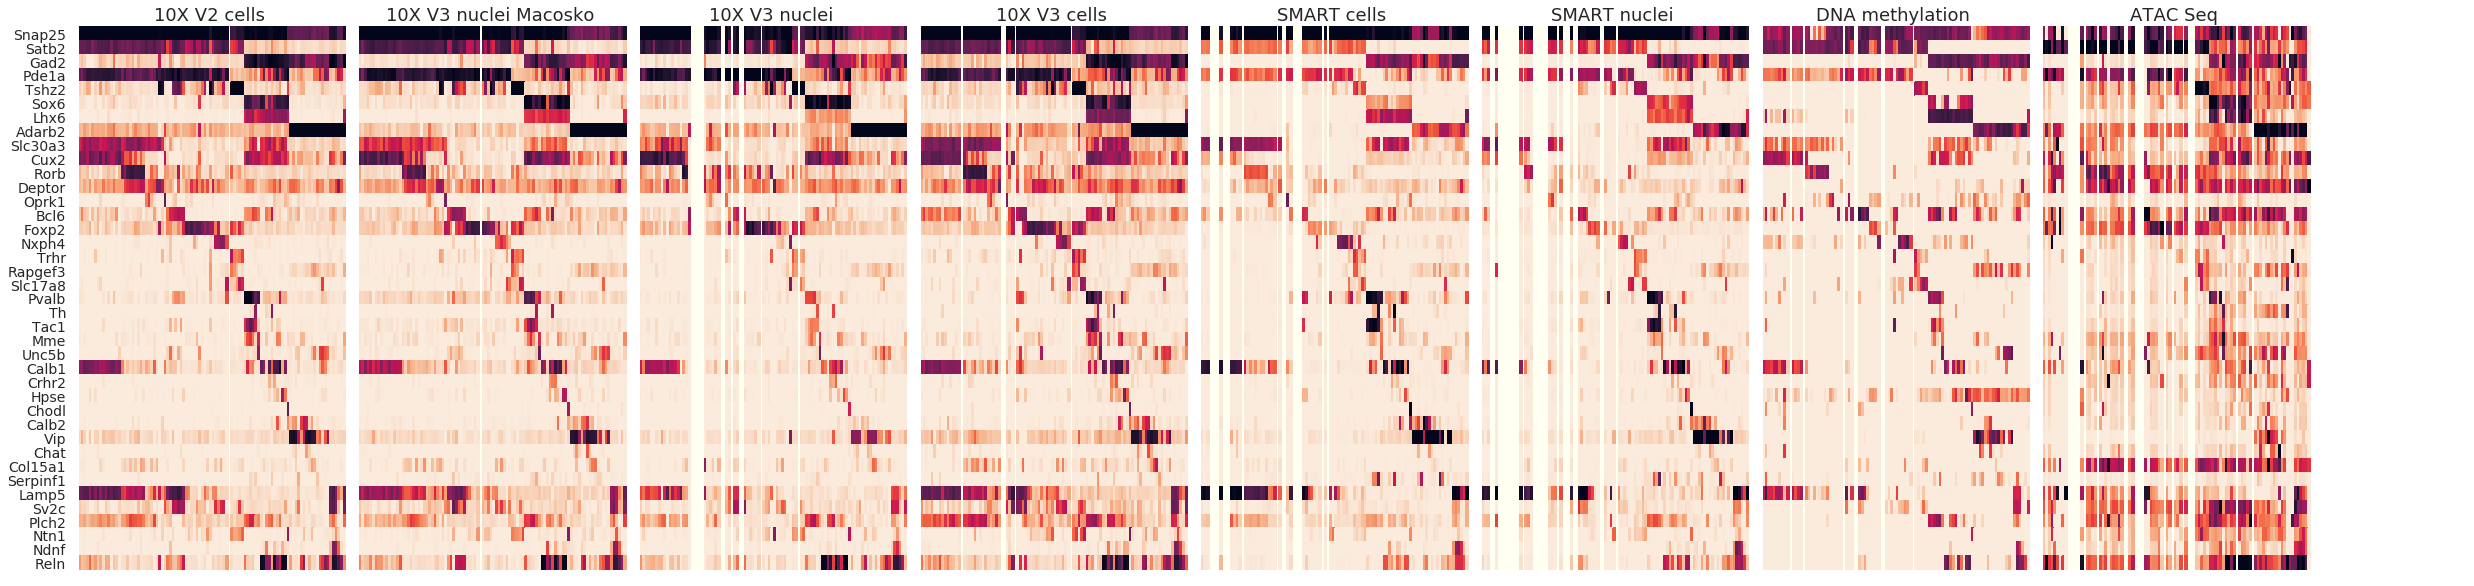

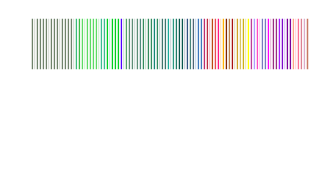

In [43]:
import scipy.cluster.hierarchy as sch
with sns.axes_style('white'):
    n = len(mods_ordered)
    nx = 8
    ny = int((n+nx-1)/nx)
    fig, axs = plt.subplots(ny, nx, figsize=(5*nx,10*ny))
    axs = axs.flatten()
    tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', genes_inq[0]
    cbar_ax = fig.add_axes([0.9, 0.2, 0.05, 0.6])
    
    for i, (ax, mod) in enumerate(zip(axs, mods_ordered[::-1])):
        if i == 0: 
            cbar = False
#             # row gene
#             Z = sch.linkage(df_plots[mod].fillna(0), method='average', metric='euclidean', optimal_ordering=True)
#             dn = sch.dendrogram(Z, no_plot=True)['leaves']
            # col clst
#             Z = sch.linkage(df_plots[mod].fillna(0).T, method='average', metric='euclidean', optimal_ordering=True)
#             dn_clst = sch.dendrogram(Z, no_plot=True)['leaves']
        else:
            cbar = False
            
        if settings[mod].mod_category == 'mc':
            vmin, vmax = -1, 0
        else:
            vmin, vmax = 0, 1
            
        g = sns.heatmap(df_plots[mod]
#                             .iloc[dn, dn_clst],
                            .loc[genes_inq, :]
#                             [order_joint_sch], 
                            [clsts_uniq], 
#                             .iloc[:, dn_clst],
                                    ax=ax, 
                                     cbar=cbar,
                                     yticklabels=True,
                                     cbar_ax=cbar_ax,
                                     cmap='rocket_r',
#                                      robust=True,
                                    vmin=vmin,
                                    vmax=vmax,
                                     )
        g.set_facecolor('#fffff2')
        ax.set_title('{} '.format(settings[mod].name, ))
        ax.set_xticks([])
        
        if i == 0:
            ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
        else:
            ax.set_yticks([])
        ax.set_xlabel('')
            
        ax.set_aspect('auto')
        
        for _, spine in ax.spines.items():
            spine.set_color(settings[mod].color)
            spine.set_linewidth(3)
        
    for ax in axs[n:]:
        ax.axis('off')
    cbar_ax.axis('off')
        
    
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    fig.savefig(output_figures.format('round4_7_gene_heatmap', 'pdf'), bbox_inches='tight')
    plt.show()
    
fig, ax_clst = plt.subplots(figsize=(5, 1))
# left_x, left_y, width, height = ax.get_position().bounds
# ax_clst = fig.add_axes((left_x, left_y-0.5*left_y, width, 0.05*height))
to_plot = pd.DataFrame()
to_plot['color'] = joint_annot.loc[clsts_uniq, 'cluster_color']
to_plot['bar'] = 1
(to_plot['bar'].plot.bar(stacked=True, width=1, 
                 alpha=1, 
                  ax=ax_clst, 
                  legend=False, 
                 color=to_plot['color'].values, 
                 )
)
ax_clst.axis('off')
fig.savefig(output_figures.format('round4_7_gene_heatmap_cluster_color_bars', 'pdf'), bbox_inches='tight')
plt.show()